Warning message:
"o pacote 'tidyverse' está em uso e não será instalado"
Warning message:
"o pacote 'scales' está em uso e não será instalado"


--- Análise do Modelo ---
Coeficiente de Regressão (inclinação): 19221 
Intercepto: 125235 
R-quadrado: 0.4892074 


--- Previsões Futuras ---
  Mes_Num        Mes Previsao
1      20 2025-08-01  509.655
2      21 2025-09-01  528.876
3      22 2025-10-01  548.097
4      23 2025-11-01  567.318
5      24 2025-12-01  586.539
6      25 2026-01-01  605.760


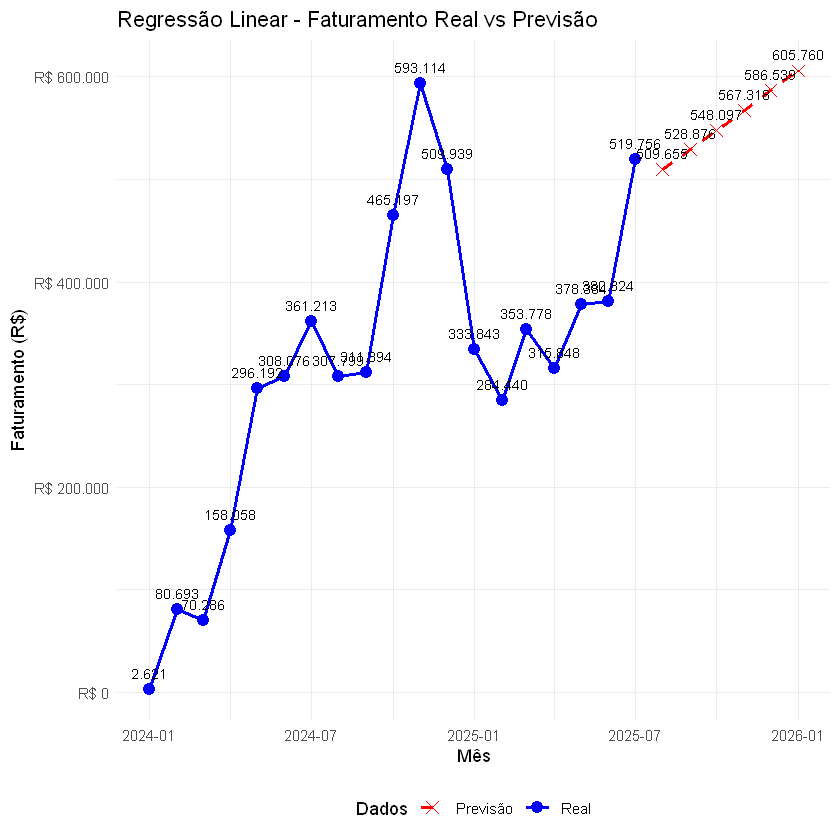

In [6]:
# Instalar e carregar as bibliotecas (instale apenas uma vez)
install.packages("tidyverse")
install.packages("scales")

library(tidyverse)
library(scales)

# ==== 1. Dados históricos ====
dados <- data.frame(
  Mes = c(
    "01/01/2024", "01/02/2024", "01/03/2024", "01/04/2024", "01/05/2024", "01/06/2024",
    "01/07/2024", "01/08/2024", "01/09/2024", "01/10/2024", "01/11/2024", "01/12/2024",
    "01/01/2025", "01/02/2025", "01/03/2025", "01/04/2025", "01/05/2025", "01/06/2025", "01/07/2025"
  ),
  Faturamento_Real = c(
    "R$ 2.620,68", "R$ 80.693,12", "R$ 70.286,31", "R$ 158.058,36", "R$ 296.191,82", "R$ 308.076,50",
    "R$ 361.212,83", "R$ 307.798,52", "R$ 311.393,62", "R$ 465.196,55", "R$ 593.113,50", "R$ 509.939,17",
    "R$ 333.842,88", "R$ 284.440,39", "R$ 353.777,76", "R$ 315.848,17", "R$ 378.383,84", "R$ 380.824,36", "R$ 519.756,48"
  )
)

# ==== 2. Preparação dos dados ====
df <- dados %>%
  mutate(
    Mes = as.Date(Mes, format = "%d/%m/%Y"),
    Faturamento_Real = as.numeric(gsub("R\\$ |\\.", "", Faturamento_Real) %>% gsub(",", ".", .)),
    Mes_Num = 1:n()
  )

# ==== 3. Treinamento do modelo ====
modelo <- lm(Faturamento_Real ~ Mes_Num, data = df)

# Exibir os coeficientes e R-quadrado
resumo_modelo <- summary(modelo)
cat("--- Análise do Modelo ---\n")
cat("Coeficiente de Regressão (inclinação):", coef(modelo)[2], "\n")
cat("Intercepto:", coef(modelo)[1], "\n")
cat("R-quadrado:", resumo_modelo$r.squared, "\n\n")

# ==== 4. Previsão de Ago/2025 a Jan/2026 ====
meses_futuros_num <- (nrow(df) + 1):(nrow(df) + 6)
df_prev <- data.frame(Mes_Num = meses_futuros_num)
previsoes <- predict(modelo, newdata = df_prev)

df_prev$Mes <- seq(from = as.Date("2025-08-01"), by = "month", length.out = 6)
df_prev$Previsao <- previsoes

# ==== 5. Criar e Exibir o gráfico ====
# Juntar os dados reais e as previsões para o gráfico
df_completo <- bind_rows(
  df %>% select(Mes, valor = Faturamento_Real),
  df_prev %>% select(Mes, valor = Previsao)
)

# Código do gráfico
grafico_final <- ggplot(df_completo, aes(x = Mes, y = valor)) +
  # Linha e pontos do faturamento real
  geom_line(data = df, aes(y = Faturamento_Real, color = "Real"), linewidth = 1) +
  geom_point(data = df, aes(y = Faturamento_Real, color = "Real"), size = 3) +
  geom_text(data = df, aes(y = Faturamento_Real, label = scales::comma(Faturamento_Real, big.mark = ".", decimal.mark = ",")), vjust = -1, size = 3) +
  # Linha e pontos da previsão
  geom_line(data = df_prev, aes(y = Previsao, color = "Previsão"), linetype = "dashed", linewidth = 1) +
  geom_point(data = df_prev, aes(y = Previsao, color = "Previsão"), size = 3, shape = 4) +
  geom_text(data = df_prev, aes(y = Previsao, label = scales::comma(Previsao, big.mark = ".", decimal.mark = ",")), vjust = -1, size = 3) +
  
  # Configurações do gráfico
  labs(
    title = "Regressão Linear - Faturamento Real vs Previsão",
    x = "Mês",
    y = "Faturamento (R$)",
    color = "Dados"
  ) +
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$ ", big.mark = ".", decimal.mark = ",")) +
  scale_color_manual(values = c("Real" = "blue", "Previsão" = "red")) +
  theme_minimal() +
  theme(legend.position = "bottom")

# Exibe o gráfico na janela de saída
print(grafico_final)

# Salva o gráfico em um arquivo com dimensões maiores
ggsave("grafico_faturamento_final.png", plot = grafico_final, width = 12, height = 8, dpi = 300)

# ==== 6. Exibir previsões formatadas ====
cat("\n--- Previsões Futuras ---\n")
print(df_prev %>% mutate(
  Previsao = scales::comma(Previsao, big.mark = ".", decimal.mark = ","),
  Mes = format(Mes, "%Y-%m-%d")
))
